# Class-discriminative attention maps for Vision Transformer
Example of applying CDAM on Vision Transformer based on SWAG weights (Supervised-Weakly through Hashtags) and finetuned on ImageNet-1K dataset.

In [1]:
import torch
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as clr
from glob import glob
import numpy as np
from types import MethodType
import copy
from classes import IMAGENET2012_CLASSES as imgnet_dict
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
imgnet_dict_inv = {v: k for k, v in imgnet_dict.items()}
idx2class = {i: j for i, j in enumerate(imgnet_dict.values())}
class2idx = {i: j for j, i in idx2class.items()}

Load Pytorch Lightning Model trained on ImageNet 

You can use your own model but have to make sure that you adjust ```patch_size```, ```image_size``` and ```final_block_norm1```.

With ```final_block_norm1``` we define the target for the gradients and activations that are used to obtain CDAM scores. \
CDAM operates on the final transformer block, where norm1 is the layer normalization before tokens enter the attention layer.

**ViT b16**

In [4]:
model = torchvision.models.vit_b_16(weights='IMAGENET1K_SWAG_E2E_V1').to(device).eval()

In [5]:
#print(model)

In [6]:
# Slight modifications to the original architecture: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# to extract attention weights.

def forward_new(self, input: torch.Tensor):
    torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
    x = self.ln_1(input)
    x, attn_output_weights = self.self_attention(x, x, x, need_weights=True, average_attn_weights=False)
    x = self.dropout(x)
    x = x + input

    y = self.ln_2(x)
    y = self.mlp(y)
    return x + y

model.encoder.layers.encoder_layer_11.forward = MethodType(forward_new, model.encoder.layers.encoder_layer_11)

In [7]:
patch_size = 16
img_size = (384, 384)

### Image loading and utils

In [8]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )
def load_img(image_path):
    """Returns the image as resized and normalized tensor and as original (only resized)"""
    with open(image_path, "rb") as f:
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize(img_size)
        original_img = copy.deepcopy(img)

    img = transform(img).to(device)

    # make image divisible by patch size
    w, h = (
        img.shape[1] - img.shape[1] % patch_size,
        img.shape[2] - img.shape[2] % patch_size,
    )
    img = img[:, :w, :h].unsqueeze(0)
    img.requires_grad = True
    return img, original_img

In [9]:
# Define custom diverging color map
mycmap = clr.LinearSegmentedColormap.from_list(
    "Random gradient 1030",
    (
        (0.000, (0.000, 0.890, 1.000)),
        (0.370, (0.263, 0.443, 0.671)),
        (0.500, (0.000, 0.000, 0.000)),
        (0.630, (0.545, 0.353, 0.267)),
        (1.000, (1.000, 0.651, 0.000)),
    ),
)

In [10]:
def get_cmap(heatmap):
    """Return a diverging colormap, such that 0 is at the center(black)"""
    if heatmap.min() > 0 and heatmap.max() > 0:
        bottom = 0.5
        top = 1.0
    elif heatmap.min() < 0 and heatmap.max() < 0:
        bottom = 0.0
        top = 0.5
    else:
        bottom = 0.5 - abs((heatmap.min() / abs(heatmap).max()) / 2)
        top = 0.5 + abs((heatmap.max() / abs(heatmap).max()) / 2)
    return cmr.get_sub_cmap(mycmap, bottom, top)

In [11]:
def plot_results(original, maps, savename=None, figsize=(9, 9)):
    """Using matplotlib, plot the original image and the relevance maps"""
    plt.figure(figsize=figsize)
    num_plots = 1 + len(maps)

    plt.subplot(1, num_plots, 1)
    plt.imshow(original)
    plt.axis("off")
    for i, m in enumerate(maps):
        plt.subplot(1, num_plots, i + 2)
        plt.imshow(m, cmap=get_cmap(m))
        plt.axis("off")
    plt.subplots_adjust(wspace=0.005, hspace=0)
    # save the plot to a file, cropped to only the image
    if savename:
        plt.savefig(f"relevance_maps/{savename}.png", bbox_inches="tight", pad_inches=0)
    plt.show()

In [12]:
def print_top_classes(predictions, **kwargs):
    """Print Top-5 predictions"""
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(idx2class[cls_idx])
        if len(idx2class[cls_idx]) > max_str_len:
            max_str_len = len(idx2class[cls_idx])

    print("Top 5 classes:")
    for cls_idx in class_indices:
        output_string = "\t{} : {}".format(cls_idx, idx2class[cls_idx])
        output_string += " " * (max_str_len - len(idx2class[cls_idx])) + "\t\t"
        output_string += "value = {:.3f}\t prob = {:.1f}%".format(
            predictions[0, cls_idx], 100 * prob[0, cls_idx]
        )
        print(output_string)

### Functions to obtain attention maps

In [13]:
def get_attention_map(model, sample_img, head=None, return_raw=False):
    """This returns the attentions when CLS token is used as query in the last attention layer, averaged over all attention heads"""
    attentions = last_selfattn["last_selfattn"]

    w_featmap = sample_img.shape[-2] // patch_size
    h_featmap = sample_img.shape[-1] // patch_size

    nh = attentions.shape[1]  # number of heads


    # this extracts the attention when cls is used as query
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    if return_raw:
        return torch.mean(attentions, dim=0).squeeze().detach().cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = torch.nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
    )[0]
    if head == None:
        mean_attention = torch.mean(attentions, dim=0).squeeze().detach().cpu().numpy()
        return mean_attention
    else:
        return attentions[head].squeeze().detach().cpu().numpy()

In [14]:
def get_CDAM(class_score, activation, grad, clip=False, return_raw=False):
    """The class_score can either be the activation of a neuron in the prediction vector or a similarity score between the latent representations of a concept and a sample"""
    class_score.backward()
    # Token 0 is CLS and others are 60x60 image patch tokens
    tokens = activation["last_att_in"][1:]
    grads = grad["last_att_in"][0][0, 1:]

    attention_scores = torch.tensor(
        [torch.dot(tokens[i], grads[i]) for i in range(len(tokens))]
    )

    if return_raw:
        return attention_scores
    else:
        # clip for higher contrast plots
        if clip:
            attention_scores = torch.clamp(
                attention_scores,
                min=torch.quantile(attention_scores, 0.01),
                max=torch.quantile(attention_scores, 0.99),
            )
        w = int(np.sqrt(attention_scores.squeeze().shape[0]))
        attention_scores = attention_scores.reshape(w, w)

        return torch.nn.functional.interpolate(
            attention_scores.unsqueeze(0).unsqueeze(0),
            scale_factor=patch_size,
            mode="nearest",
        ).squeeze()

### Define hooks for token activations and gradients before they enter last attention

In [15]:
# function to extract activation
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()

    return hook


# function to extract gradients
grad = {}

def get_gradient(name):
    def hook(model, input, output):
        grad[name] = output

    return hook


# function to extract attention
last_selfattn = {}

def get_last_selfattn(name):
    def hook(model, input, output):
        last_selfattn[name] = output[1].detach()

    return hook

In [16]:
# registering hooks:

final_block_norm1 = model.encoder.layers.encoder_layer_11.ln_1
final_block_selfattn = model.encoder.layers.encoder_layer_11.self_attention


activation_hook = final_block_norm1.register_forward_hook(
    get_activation("last_att_in")
)
grad_hook = final_block_norm1.register_full_backward_hook(
    get_gradient("last_att_in")
)
last_selfattn_hook = final_block_selfattn.register_forward_hook(
    get_last_selfattn("last_selfattn")
)

In [17]:
def get_maps(model, img, target_class, return_raw=False, clip=False):
    """Wrapper function to get the attention map and the concept map for a given image and target class"""
    class_idx = class2idx[target_class]
    pred = model(img)
    class_attention_map = get_CDAM(
        class_score=pred[0][class_idx],
        activation=activation,
        grad=grad,
        return_raw=return_raw,
        clip=clip
    )
    attention_map = get_attention_map(model, img, return_raw=return_raw)
    return attention_map, class_attention_map

### Visualizing class score 

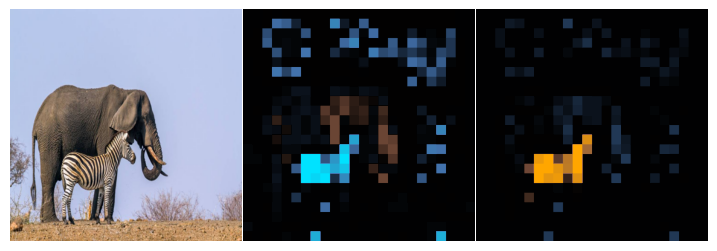

In [18]:
img_path = "images/elephant-zebra.jpg" 
sample_img, original_img = load_img(img_path)
sample_img.requires_grad = True

attention_map, class_attention_map1 = get_maps(model, sample_img, "African elephant, Loxodonta africana", clip=True) 
attention_map, class_attention_map2 = get_maps(model, sample_img, "zebra" , clip=True)

plot_results(original_img, [class_attention_map1, class_attention_map2])

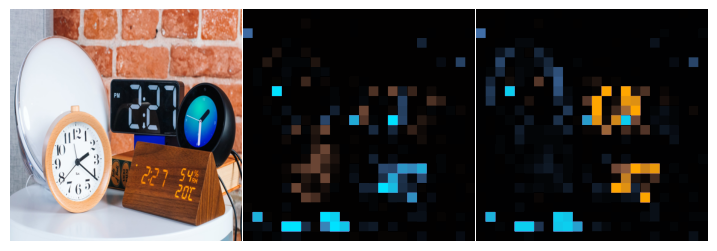

In [19]:
img_path = "images/clocks.jpg"
sample_img, original_img = load_img(img_path)
sample_img.requires_grad = True

attention_map, class_attention_map1 = get_maps(model, sample_img, "analog clock", clip=True) 
attention_map, class_attention_map2 = get_maps(model, sample_img, "digital clock" , clip=True)

plot_results(original_img, [class_attention_map1, class_attention_map2])

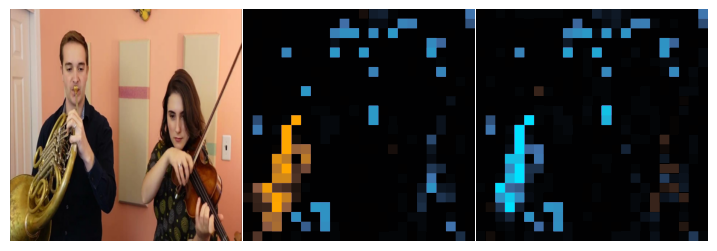

In [20]:
img_path = "images/hornviolin.jpg"
sample_img, original_img = load_img(img_path)
sample_img.requires_grad = True

attention_map, class_attention_map1 = get_maps(model, sample_img, "French horn, horn", clip=True) 
attention_map, class_attention_map2 = get_maps(model, sample_img, "violin, fiddle" , clip=True)

plot_results(original_img, [class_attention_map1, class_attention_map2])

### Examples on ImageNet

In [43]:
imgnet_val_path = "/home/dzban112/ImageNet/val/*"
val_images = glob(imgnet_val_path)

In [57]:
def plotOnImageNet():
    imgnet_val_path = "/home/dzban112/ImageNet/val/*"
    val_images = glob(imgnet_val_path)
    for i, img_path in enumerate(val_images[990:1010]):
        sample_img, original_image = load_img(img_path)
        sample_img.requires_grad = True
        pred = model(sample_img)
        predicted_class = idx2class[int(torch.argmax(pred))]
        attention_map, cdam = get_maps(model, sample_img, predicted_class, clip=True)
        fig, axs = plt.subplots(1, 3, figsize=(9, 4), layout='constrained')
        axs[0].imshow(original_image)
        axs[0].set_title("Original Image")
        axs[0].tick_params(axis='both',
                           which='both', 
                           bottom=False, 
                           left=False,
                           labelbottom=False,
                           labelleft=False
                          )
        axs[1].imshow(attention_map, cmap=get_cmap(attention_map))
        axs[1].set_title("Attention Map")
        axs[1].tick_params(axis='both',
                           which='both', 
                           bottom=False, 
                           left=False,
                           labelbottom=False,
                           labelleft=False
                          )
        axs[2].imshow(cdam, cmap=get_cmap(cdam))
        axs[2].set_title("CDAM|"+predicted_class.split(',')[0])
        axs[2].tick_params(axis='both',
                           which='both', 
                           bottom=False, 
                           left=False,
                           labelbottom=False,
                           labelleft=False
                          )
        print(i)
        plt.savefig(f"relevance_maps/{i}.png", bbox_inches="tight", format="png", transparent=True)
        plt.show()
        

0


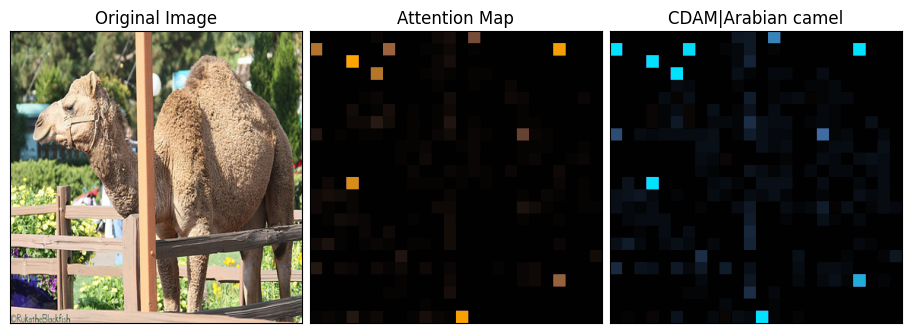

1


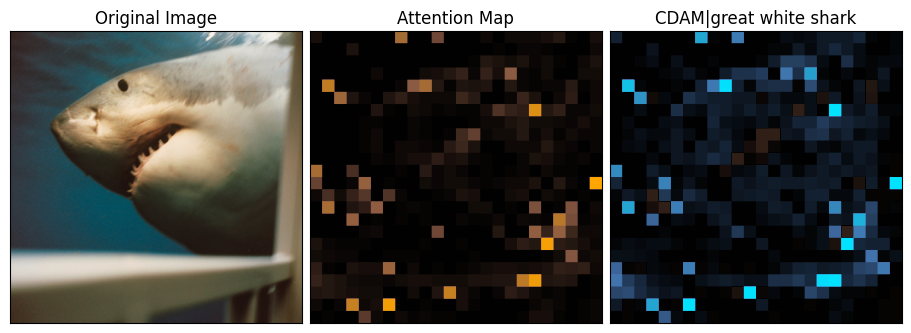

2


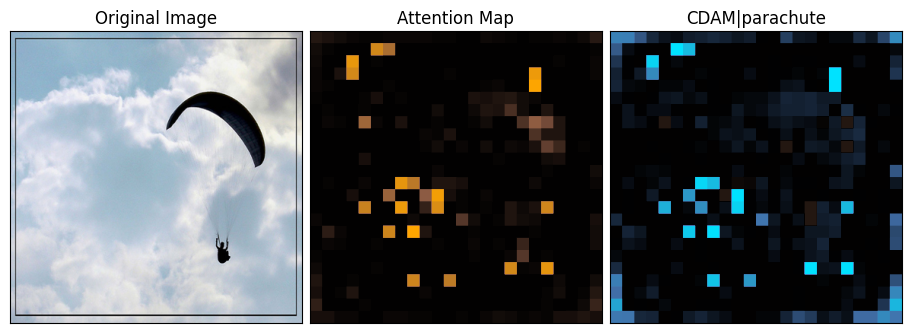

3


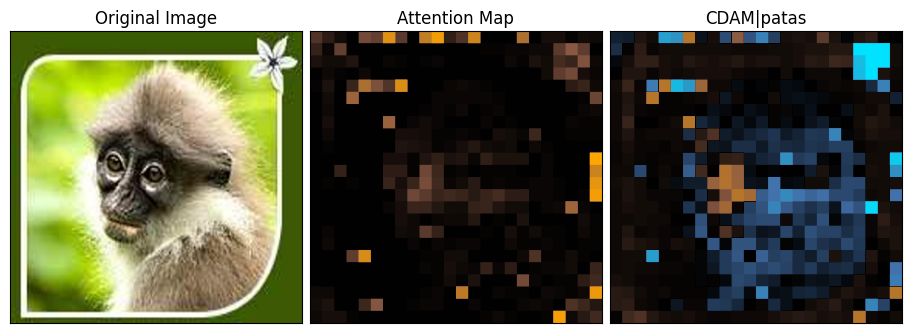

4


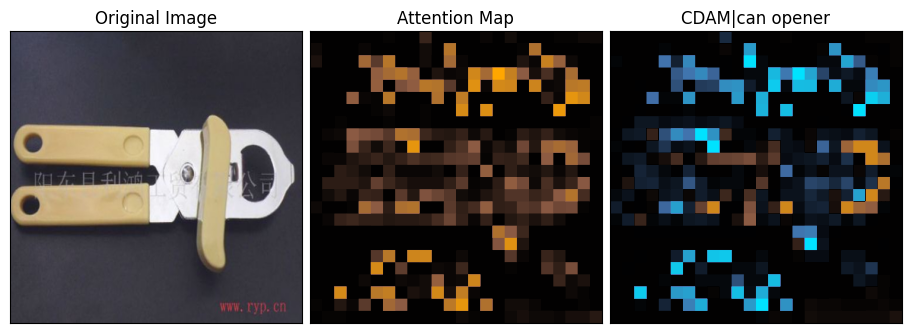

5


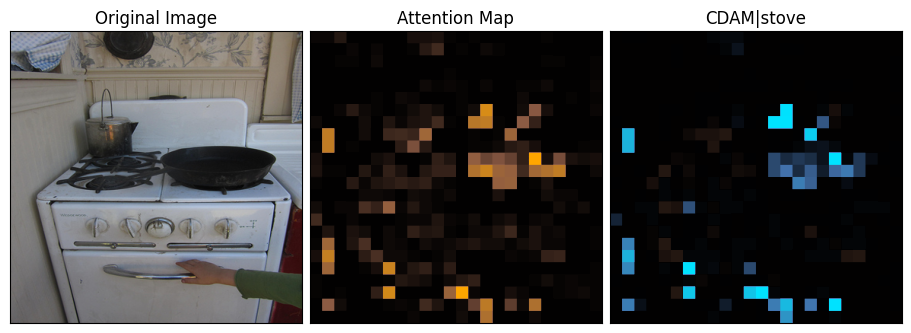

6


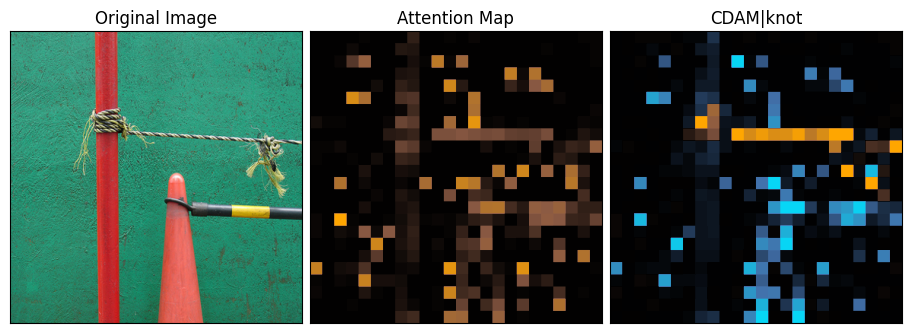

7


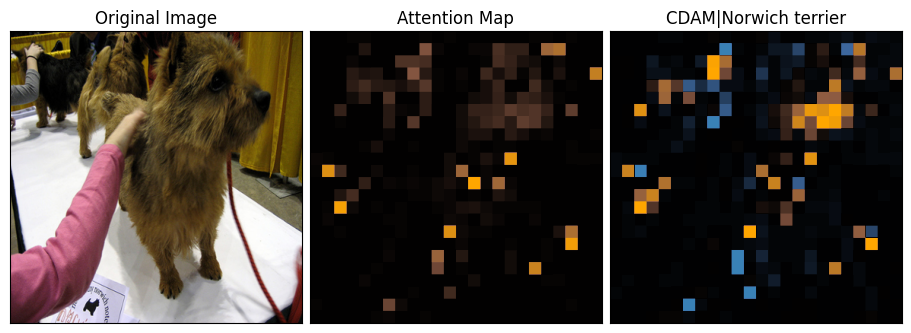

8


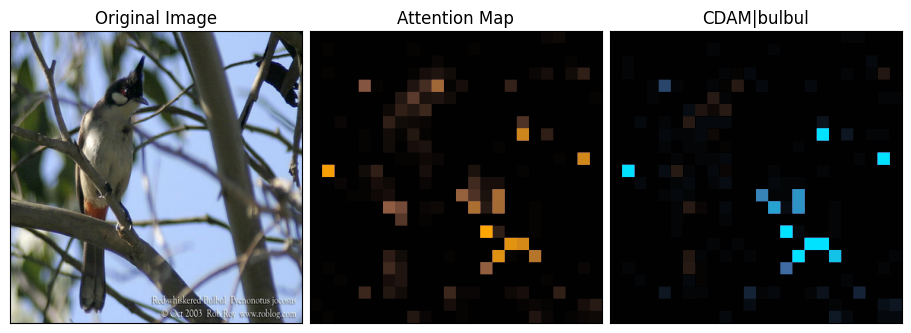

9


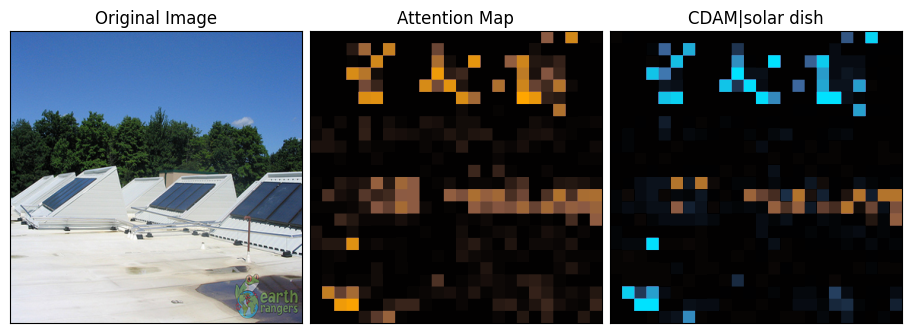

10


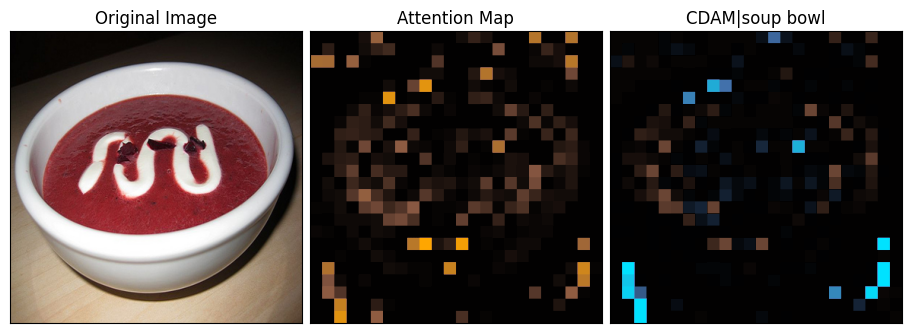

11


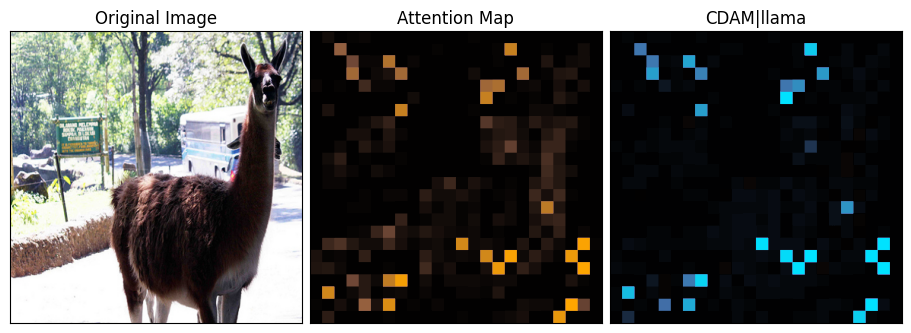

12


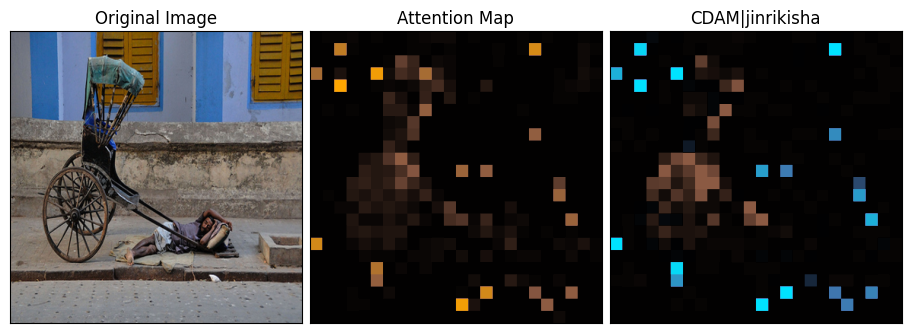

13


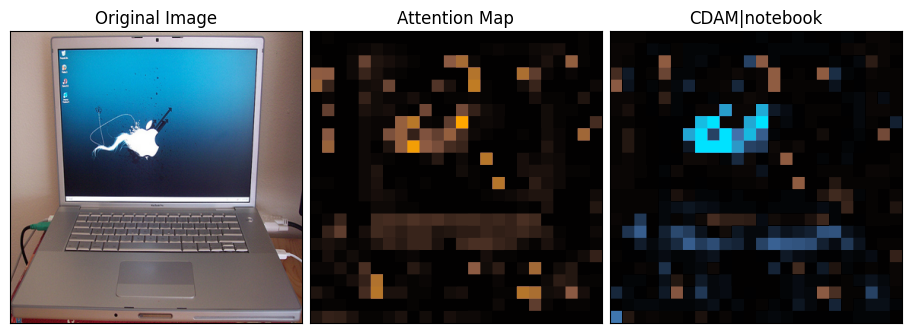

14


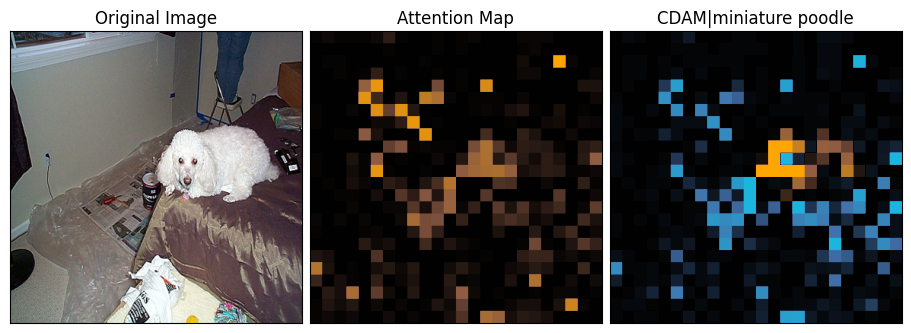

15


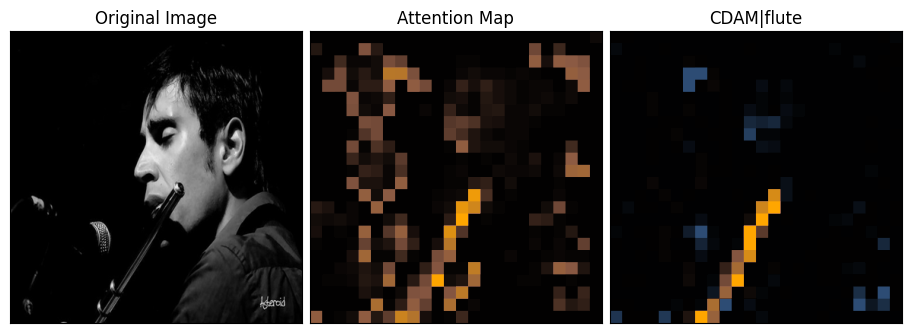

16


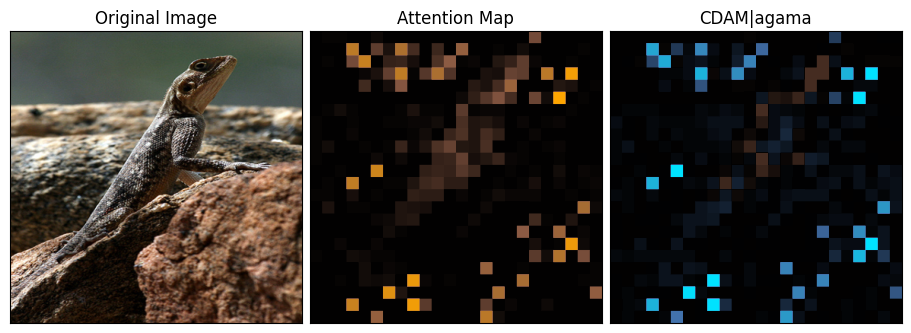

17


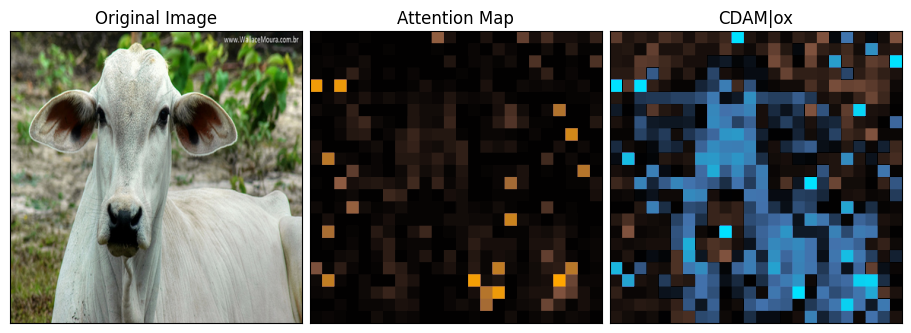

18


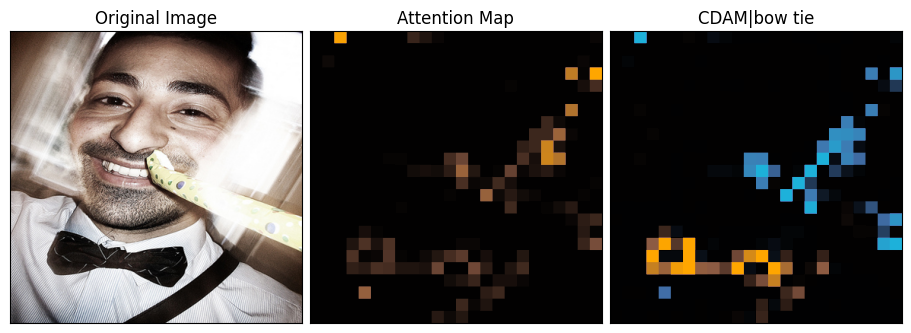

19


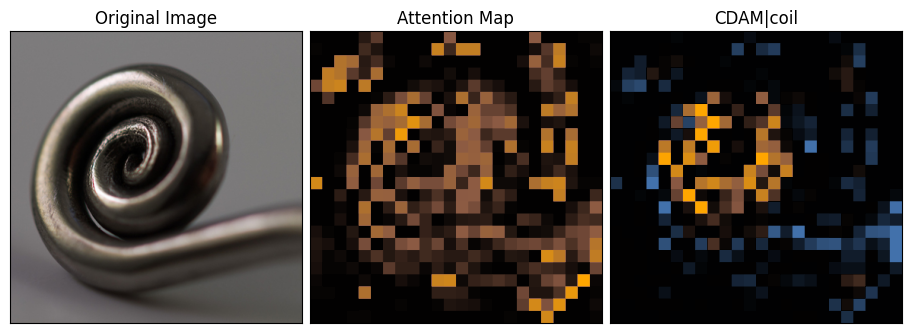

In [58]:
plotOnImageNet()

## Raw CDAM

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_raw(original, maps, savename=None, figsize=(9, 9), cmap='viridis'):
    """Using matplotlib, plot the original image and the relevance maps with consistent color scale"""
    plt.figure(figsize=figsize)
    num_plots = 1 + len(maps)

    # Determine the global min and max values across all maps to set a consistent scale
    all_values = np.concatenate([m.flatten() for m in maps])
    vmin, vmax = all_values.min(), all_values.max()

    plt.subplot(1, num_plots, 1)
    plt.imshow(original)
    plt.axis("off")
    
    for i, m in enumerate(maps):
        plt.subplot(1, num_plots, i + 2)
        plt.imshow(m, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.axis("off")
        
    plt.subplots_adjust(wspace=0.005, hspace=0)
    
    # Save the plot to a file, cropped to only the image
    if savename:
        plt.savefig(f"relevance_maps/{savename}.png", bbox_inches="tight", pad_inches=0)
    
    plt.show()

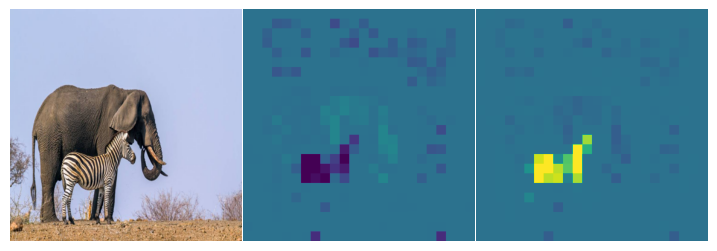

In [61]:
plot_results_raw(original_img, [class_attention_map1, class_attention_map2])

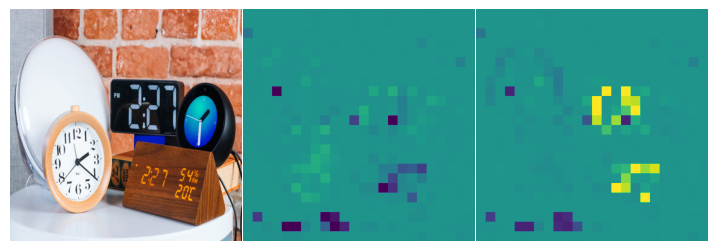

In [63]:
plot_results_raw(original_img, [class_attention_map1, class_attention_map2])

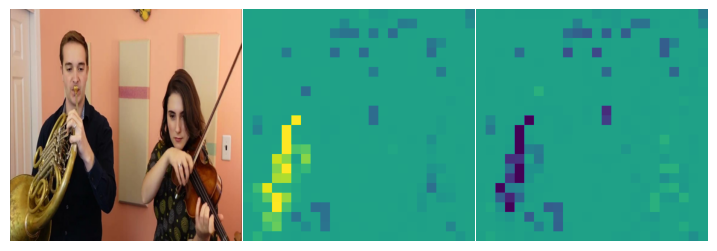

In [65]:
plot_results_raw(original_img, [class_attention_map1, class_attention_map2])